# Impact of price concessions in NHS in England

## 1.  Import data into notebook

In [1]:
#import tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from IPython.display import HTML
from datetime import datetime

#Suppress scientific notation#
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
#import from bigquery, including estriol correction
projectid = "ebmdatalab"

df = pd.read_gbq("""
SELECT
  DATE(presc.month) AS month,
  ncso.bnf_code,
  ncso.dmd_name,
  CASE
    WHEN ncso.bnf_code='0702010F0AAACAC' THEN SUM(presc.quantity/80) #adjusting estriol cream quantity
    ELSE SUM(presc.quantity)
  END AS quantity,
  ncso.dmd_quantity,
  ncso.ncso_price,
  dt.dt_price,
  CASE
    WHEN ncso.bnf_code='0702010F0AAACAC' THEN SUM(((ncso.ncso_price-dt.dt_price)/ncso.dmd_quantity)/100*(presc.quantity/80)) # adjusting estriol cream quantity
    ELSE SUM(((ncso.ncso_price-dt.dt_price)/ncso.dmd_quantity)/100*quantity)
  END AS excess_cost
FROM
  richard.price_concessions AS ncso
INNER JOIN
  ebmdatalab.hscic.prescribing AS presc
ON
  presc.month=ncso.month
  AND presc.bnf_code=ncso.bnf_code
INNER JOIN
  richard.drug_tariff AS dt
ON
  dt.month = ncso.month
  AND dt.vmpp = ncso.vmpp
GROUP BY
  month,
  ncso.bnf_code,
  ncso.dmd_name,
  ncso.ncso_price,
  dt.dt_price,
  ncso.dmd_quantity
ORDER BY
  month,
  ncso.dmd_name
""", projectid,dialect='standard')

Requesting query... ok.
Job ID: job_AjXuABkSIatralvsJfJdDjVWWauN
Query running...
Query done.
Cache hit.

Retrieving results...
Got 854 rows.

Total time taken 1.21 s.
Finished at 2017-12-05 09:32:01.


In [3]:
#create month as index for graphing purposes
df['month'] = pd.to_datetime(df['month'])
df.index = df['month']
del df['month']

## 2.  Showing change over time in excess cost

In [8]:
#create grouped df for excess cost
time_df=df.groupby([df.index]).sum()
#create table version (without index and other columns and format number)
tbl_time_df = time_df[['excess_cost']].copy()
tbl_time_df.reset_index(level=0, inplace=True)
tbl_time_df['excess_cost'] = tbl_time_df['excess_cost'].map('£{:,.0f}'.format) 

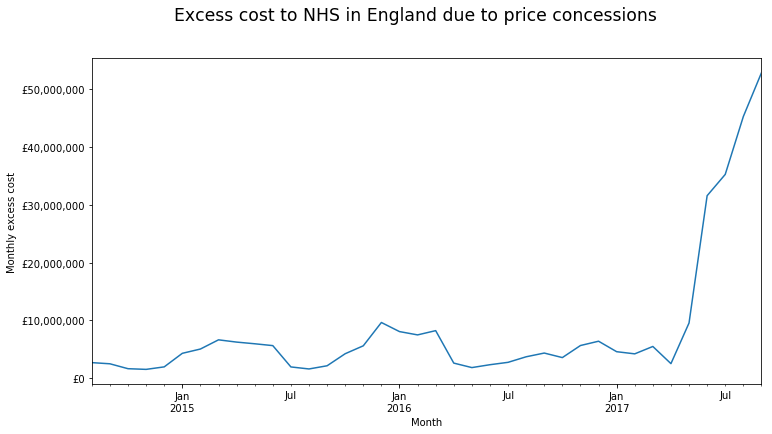

In [18]:
#Plot excess cost chart
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
time_df.plot(ax=ax, legend=False, y='excess_cost')
fmt = '£{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax.set_xlabel("Month")
ax.set_ylabel("Monthly excess cost")
plt.suptitle('Excess cost to NHS in England due to price concessions', x=0.5, y=1, ha='center', fontsize='xx-large')
plt.show()

In [19]:
#produce HTML table of costs
HTML(tbl_time_df.to_html(index=False, classes='table table-striped'))


month,excess_cost
2014-08-01,"£2,688,762"
2014-09-01,"£2,485,712"
2014-10-01,"£1,636,428"
2014-11-01,"£1,519,747"
2014-12-01,"£1,952,294"
2015-01-01,"£4,297,831"
2015-02-01,"£5,040,827"
2015-03-01,"£6,631,585"
2015-04-01,"£6,240,501"
2015-05-01,"£5,951,586"


## 3.  Showing cumulative costs in 2017-18

In [31]:
#create 2017-18 dataframe
fy_time_df= time_df.loc[time_df.index >= '2017-04-01']
fy_time_df['cumulative_cost'] = fy_time_df.excess_cost.cumsum()

#create table version (without index and other columns and format number)
tbl_fy_time_df = fy_time_df[['excess_cost', 'cumulative_cost']].copy()
tbl_fy_time_df.reset_index(level=0, inplace=True)
tbl_fy_time_df['excess_cost'] = tbl_fy_time_df['excess_cost'].map('£{:,.0f}'.format)
tbl_fy_time_df['cumulative_cost'] = tbl_fy_time_df['cumulative_cost'].map('£{:,.0f}'.format) 

C:\Users\racro\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


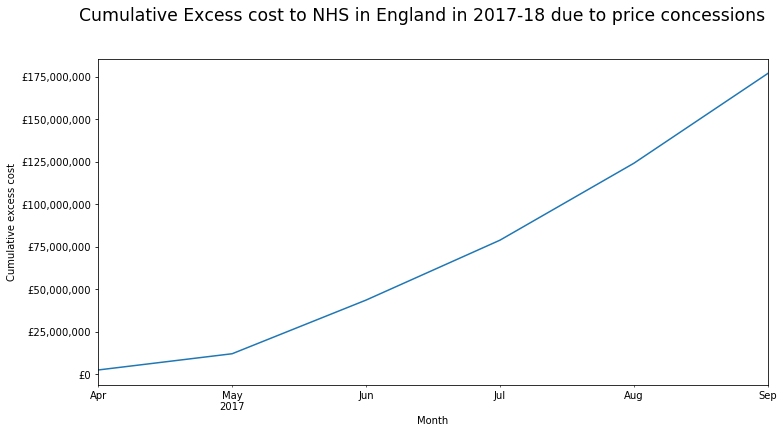

In [35]:
#draw graph
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
fy_time_df.plot(ax=ax, legend=False, y='cumulative_cost')
fmt = '£{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax.set_xlabel("Month")
ax.set_ylabel("Cumulative excess cost")
plt.suptitle('Cumulative Excess cost to NHS in England in 2017-18 due to price concessions', x=0.5, y=1, ha='center', fontsize='xx-large')
plt.show()

In [36]:
#produce HTML table of costs
HTML(tbl_fy_time_df.to_html(index=False, classes='table table-striped'))

month,excess_cost,cumulative_cost
2017-04-01,"£2,513,041","£2,513,041"
2017-05-01,"£9,549,333","£12,062,374"
2017-06-01,"£31,573,865","£43,636,239"
2017-07-01,"£35,258,470","£78,894,709"
2017-08-01,"£45,271,689","£124,166,398"
2017-09-01,"£52,830,450","£176,996,848"


## 4. Top 20 Formulations and their costs in 2017-2018

In [83]:
#create 2017-18 dataframe
cfy_df= df.loc[df.index >= '2017-04-01']

In [119]:
#create top 20 of costs grouped by dmd_name
cfy_df=cfy_df.groupby(['dmd_name']).sum()
tbl_cfy_df = cfy_df[['excess_cost']].copy()
tbl_cfy_df.reset_index(level=0, inplace=True)
tbl_cfy_df.sort_values('excess_cost', inplace=True, ascending=False)
tbl_cfy_df=tbl_cfy_df.nlargest(20,'excess_cost')
tbl_cfy_df['excess_cost'] = tbl_cfy_df['excess_cost'].map('£{:,.0f}'.format)

In [120]:
HTML(tbl_cfy_df.to_html(index=False, classes='table table-striped'))

dmd_name,excess_cost
Sumatriptan 50mg tablets,"£17,418,879"
Olanzapine 10mg tablets,"£12,853,700"
Gabapentin 300mg capsules,"£9,325,831"
Quetiapine 100mg tablets,"£9,137,526"
Quetiapine 25mg tablets,"£8,912,723"
Mefenamic acid 500mg tablets,"£8,758,719"
Levetiracetam 500mg tablets,"£8,720,187"
Sumatriptan 100mg tablets,"£6,256,685"
Quetiapine 200mg tablets,"£6,195,682"
Olanzapine 5mg tablets,"£5,998,957"
